/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - loss: 0.7077 - mae: 0.5424 - val_loss: 0.0306 - val_mae: 0.0501 - learning_rate: 2.0000e-04
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.3079 - mae: 0.3622 - val_loss: 0.0314 - val_mae: 0.0918 - learning_rate: 2.0000e-04
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - loss: 0.1959 - mae: 0.2707 - val_loss: 0.0282 - val_mae: 0.0544 - learning_rate: 1.0000e-04
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - loss: 0.1332 - mae: 0.2304 - val_loss: 0.0399 - val_mae: 0.1449 - learning_rate: 1.0000e-04
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - loss: 0.1014 - mae: 0.1975 - val_loss: 0.0310 - val_mae: 0.1039 - learning_rate: 5.0000e-05
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Mean Absolute Error (MAE): 43.3455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

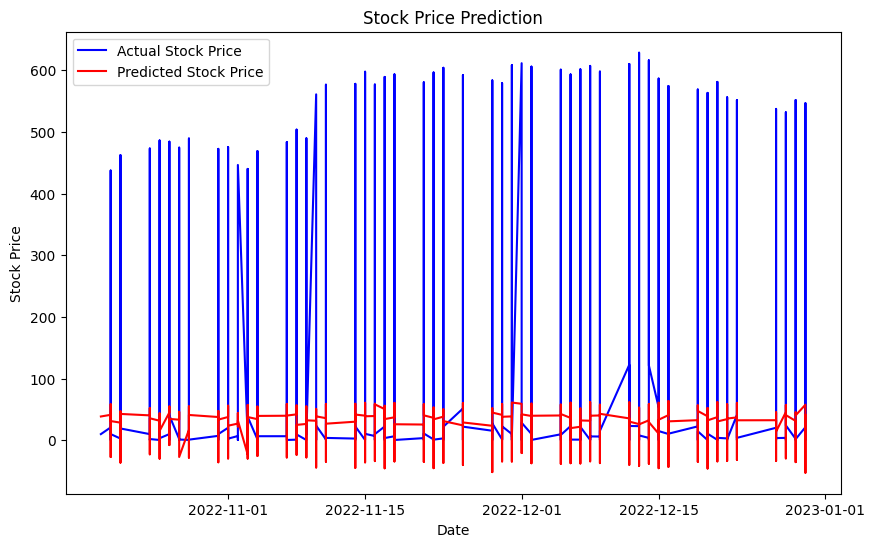

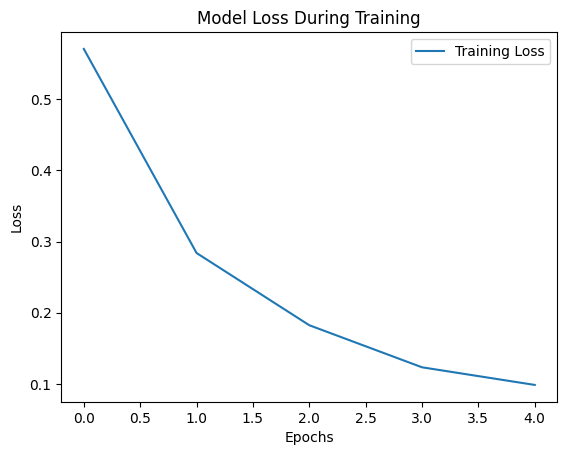

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
data = pd.read_csv('infolimpioavanzadoTarget.csv')

# Convert 'date' to datetime and sort by date
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

# Use only the 'close' price for prediction
close_prices = data['close'].values.reshape(-1, 1)

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences (X) and the corresponding labels (y)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 30  # Increased sequence length for better context
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM/GRU (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the Hybrid GRU + LSTM model
model = Sequential()

# GRU Layer (Faster) for feature extraction
model.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layer (More Accurate) for sequence learning
model.add(LSTM(units=128, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1, kernel_regularizer='l2'))  # L2 regularization to reduce overfitting

# Compile the model with an Adam optimizer
optimizer = Adam(learning_rate=0.0002, clipnorm=1.0)  # Reduced learning rate for gradual learning
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Predictions on the test data
predicted_prices = model.predict(X_test)

# Undo scaling for predictions and actual values
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")



# Function for future predictions
def predict_future_prices(model, last_data, num_predictions):
    predictions = []
    current_sequence = last_data[-seq_length:].reshape(1, seq_length, 1)
    for _ in range(num_predictions):
        next_price = model.predict(current_sequence)
        predictions.append(next_price[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], next_price.reshape(1, 1, 1), axis=1)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predicting the next 10 future prices
future_prices = predict_future_prices(model, scaled_data, num_predictions=10)
print("Future Predictions:", future_prices.flatten())

# Plotting the predicted vs actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['date'].iloc[train_size + seq_length:], actual_prices, color='blue', label='Actual Stock Price')
plt.plot(data['date'].iloc[train_size + seq_length:], predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

